In [1]:
import pandas as pd
import numpy as np
import ast 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import re
import unicodedata

/Users/alextabora/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
articles = pd.read_csv("../files/criminal_articles.csv")
# cast string into array
articles.loc[:,"title"] = articles.title.apply(lambda x: ast.literal_eval(x) )
articles.loc[:,"content"] = articles.content.apply(lambda x: ast.literal_eval(x) )
articles.loc[:,"relationships"] = articles.relationships.apply(lambda x: ast.literal_eval(x) )

In [3]:
articles.head()

,article_id,title,content,relationships
0,3,"[[Citan, none], [a, none], [11, none], [person...","[[[SAN, B-City], [PEDRO, I-City], [SULA, I-Cit...","[[{u'tag': u'B-Col', u'word': u'lomas del carm..."
1,5,"[[DEI, none], [pide, none], [denunciar, none],...","[[[TEGUCIGALPA, B-City]], [[-, none], [Autorid...",[]
2,9,"[[Alcaldía, none], [intensifica, none], [opera...","[[[TEGUCIGALPA, B-City]], [[-, none], [Pese, n...","[[{u'tag': u'B-Col', u'word': u'kennedy'}, {u'..."
3,11,"[[Pasajeros, none], [asaltantes, none], [acrib...","[[[PUERTO, B-City], [CORTES, I-City], [,, none...","[[{u'tag': u'B-City', u'word': u'puerto cortes..."
4,12,"[[Fallece, none], [comerciante, none], [olanch...","[[[JUTICALPA, B-City], [,, none], [Olancho, B-...","[[{u'tag': u'B-City', u'word': u'juticalpa'}, ..."


# 1. Preprocess??

In [4]:
# very useful function to avoid mispellings problems.
# you'll thank me later
def to_ascii(s):
    return unicodedata.normalize('NFKD', s).encode('ascii', 'ignore')

def sent_to_ascii(sentences):
    for sent_ix, sent in enumerate(sentences):
        for word_ix, word in enumerate(sent):
            sentences[sent_ix][word_ix][0] =  to_ascii(word[0])
    return sentences
            
def rel_to_ascii(relationships):
    for rel_ix, rel in enumerate(relationships):
        relationships[rel_ix][0]["word"] = to_ascii(relationships[rel_ix][0]["word"])
        relationships[rel_ix][1]["word"] = to_ascii(relationships[rel_ix][1]["word"])
    return relationships
    

#Apply it to all the words once and for all to get freedom!
articles.title = articles.title.apply(lambda x: sent_to_ascii([x]) if x != None else x )
articles.content = articles.content.apply(lambda x: sent_to_ascii(x) if x != None else x )
articles.relationships = articles.relationships.apply(lambda x: rel_to_ascii(x) if x != None else x )


## 1.1 Get the entities... 

In [5]:
def getEntities(content):
    entities = []
    for sent in content:
        for word in sent:
            if word[1][0] == "B":
                entities.append({"word": word[0].lower(),"tag":word[1][2:]})
            elif word[1][0] == "I":
                entities[-1]["word"] += " " + word[0].lower()
                
    #eliminate duplicates
    unique_entities = []
    for itm in entities:
        if itm not in unique_entities:
            unique_entities.append(itm)
                
    return unique_entities

articles.loc[:,"full_text"] = articles.title.apply(lambda x: x) + articles.content 
articles.loc[:,"entities"] = articles.full_text.apply(lambda x: getEntities(x))
articles.loc[3].entities

[{'tag': u'City', 'word': 'puerto cortes'},
 {'tag': u'State', 'word': 'cortes'},
 {'tag': u'City', 'word': 'choloma'},
 {'tag': u'Col', 'word': 'lopez arellano'},
 {'tag': u'Zone', 'word': 'trincheras'}]

In [6]:
def formatRelationships(relationships):

    for ix, rel in enumerate(relationships):
        relationships[ix][0]["tag"] = rel[0]["tag"][2:]
        relationships[ix][1]["tag"] = rel[1]["tag"][2:]
    return relationships
                          
articles.relationships.apply(lambda x: formatRelationships(x))
articles.head().relationships[3]
        

[[{u'tag': u'City', u'word': 'puerto cortes'},
  {u'tag': u'State', u'word': 'cortes'}],
 [{u'tag': u'Col', u'word': 'lopez arellano'},
  {u'tag': u'City', u'word': 'puerto cortes'}],
 [{u'tag': u'Zone', u'word': 'trincheras'},
  {u'tag': u'City', u'word': 'puerto cortes'}],
 [{u'tag': u'City', u'word': 'choloma'},
  {u'tag': u'State', u'word': 'cortes'}]]

## Prepare Data

In [7]:
def getLevelsCount(entities):
    levels = {
        "Country": 0,
        "State": 0,
        "City": 0,
        "Zone": 0,
        "Col": 0,
        "Res": 0,
        "Bar": 0,
    }
    for entity in entities:
        if entity["tag"] == "Misc":
            pass
        else:
            levels[entity["tag"]] += 1  
    return levels

def getLevelHeight(levels):
    count = 0
    if levels["Country"] > 0:
        count += 1
    if levels["City"] > 0:
        count += 1
    if levels["State"] > 0:
        count += 1 
    if levels["Zone"] > 0 or levels["Col"] > 0 \
        or levels["Res"] > 0 or levels["Bar"] > 0:
        count += 1 
    return count

articles.loc[:,"level_count"] = articles.entities.apply(lambda x: getLevelsCount(x) )
articles.loc[:,"level_height"] = articles.level_count.apply(lambda x: getLevelHeight(x))
#Levels
articles.loc[:,"Country"] = articles.level_count.apply(lambda x: x["Country"])
articles.loc[:,"State"] = articles.level_count.apply(lambda x: x["State"])
articles.loc[:,"City"] = articles.level_count.apply(lambda x: x["City"])
articles.loc[:,"Zone"] = articles.level_count.apply(lambda x: x["Zone"])
articles.loc[:,"Col"] = articles.level_count.apply(lambda x: x["Col"])
articles.loc[:,"Res"] = articles.level_count.apply(lambda x: x["Res"])
articles.loc[:,"Bar"] = articles.level_count.apply(lambda x: x["Bar"])
articles.loc[:,"Zone_group"] = articles.Zone + articles.Col + articles.Res + articles.Bar

articles.loc[:,"number_relationships"] = articles.relationships.apply(lambda x: len(x))
articles.loc[:,"number_entities"] = articles.entities.apply(lambda x: len(x))



print articles.loc[0].entities
print
print articles.loc[0].level_count
print articles.loc[0].level_height

[{'tag': u'City', 'word': 'san pedro sula'}, {'tag': u'Col', 'word': 'lomas del carmen'}, {'tag': u'Zone', 'word': 'monumento a la madre'}, {'tag': u'Zone', 'word': 'primera avenida'}, {'tag': u'Zone', 'word': 'parque central'}]

{'City': 1, 'Bar': 0, 'Zone': 3, 'Res': 0, 'State': 0, 'Country': 0, 'Col': 1}
2


## General Summary Stats  

In [8]:
articles[["level_height", "Country", "State", "City", "Zone", "Col", "Res", "Bar","Zone_group", "number_relationships", "number_entities"]].describe()

,level_height,Country,State,City,Zone,Col,Res,Bar,Zone_group,number_relationships,number_entities
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000,309.000000
mean,2.427184,0.644013,0.624595,1.699029,0.501618,0.572816,0.012945,0.100324,1.187702,2.614887,4.194175
std,0.996115,1.039545,0.743921,1.295609,1.052593,1.234793,0.113221,0.341359,1.923128,2.337700,2.875303
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
50%,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,4.000000
75%,3.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,4.000000,5.000000
max,4.000000,8.000000,4.000000,7.000000,9.000000,11.000000,1.000000,2.000000,15.000000,15.000000,19.000000


In [9]:
# DISCONSIDER those that have less than 2 entities... cuase they don't have enough entities to have a single relationship
print articles[(articles["number_entities"]<2)].article_id.count()
print articles[(articles["number_entities"]<2)&(articles["number_relationships"]>0)].article_id.count()

articles = articles[articles["number_entities"]>=2]

35
0


## Levels per Article

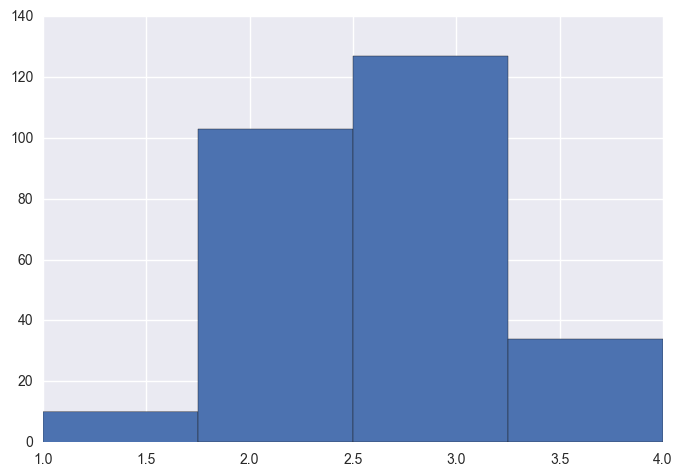

In [10]:
articles.level_height.hist(bins=4)
plt.show()

## Number of relationships per article distribution

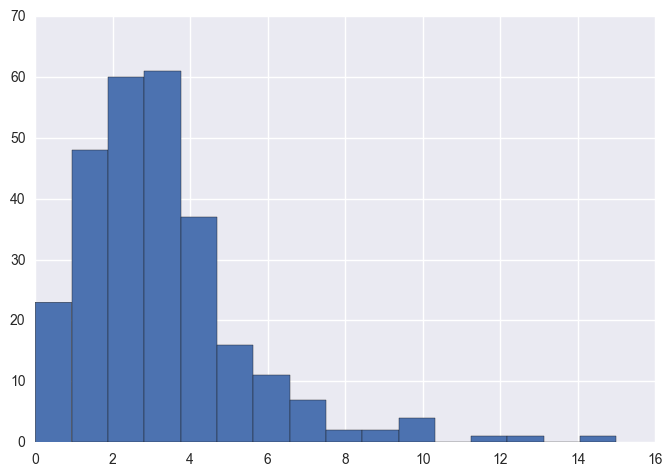

In [11]:
articles.number_relationships.hist(bins=16)
plt.show()

## Number of entities per article Distribution

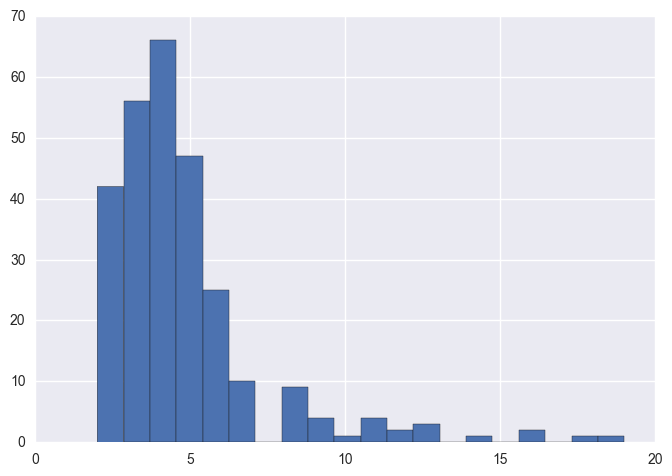

In [12]:
articles.number_entities.hist(bins=20)
plt.show()

## Corelations

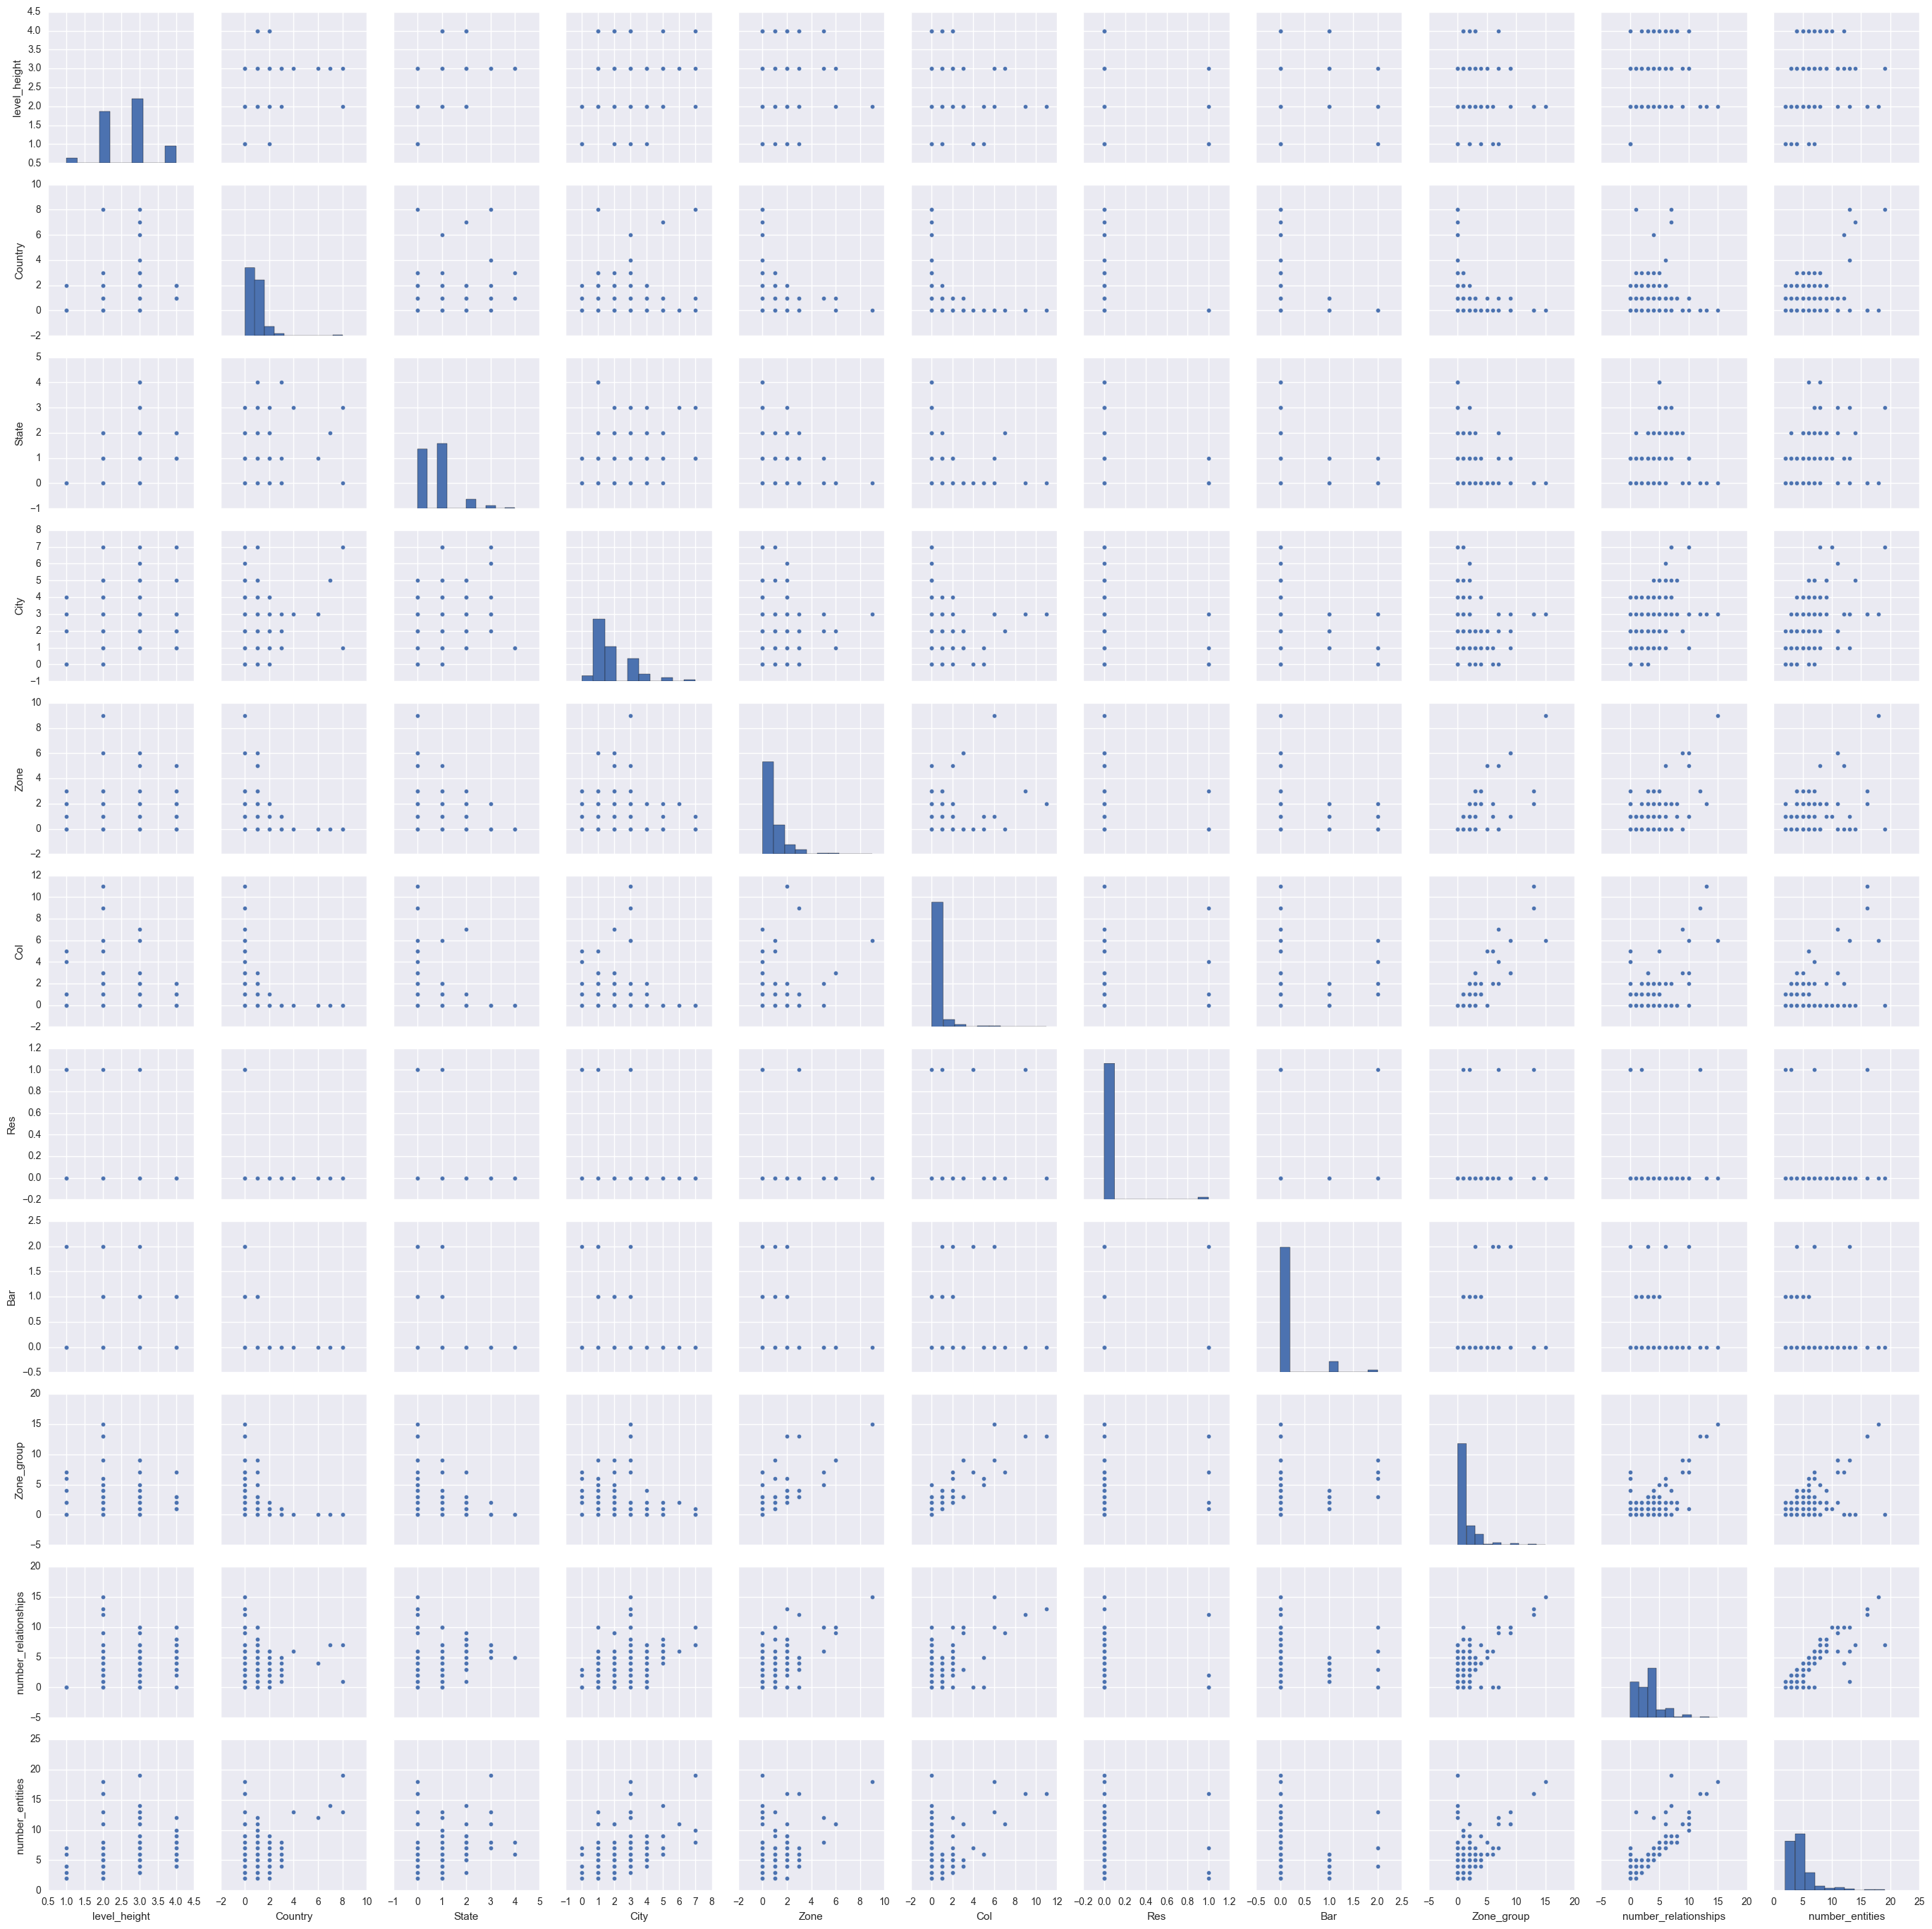

In [13]:
sns.pairplot(articles[["level_height", "Country", "State", "City", "Zone", "Col", "Res", "Bar","Zone_group", "number_relationships", "number_entities"]])
plt.show()

## Relationships

Label examples:   
    Label            Level
- City-Country  and  3-1
- City-State    and  3-2
- Col-City      and  4-3
- Res-Country   and  4-1



In [14]:
# separate the data
def format_relationships(df):
    level_map = {
        "Country": 1,
        "State": 2,
        "City": 3,
        "Zone": 4,
        "Col": 4,
        "Res": 4,
        "Bar": 4
    }
    
    data = []
    for art_id, article in articles.iterrows():
        for rel_id, relation in enumerate(article.relationships):
            child = relation[0]["tag"]
            parent = relation[1]["tag"]
            data.append([
                article.article_id, rel_id,
                child, parent,
                level_map[child],level_map[parent],
                relation[0]["word"], relation[1]["word"]
            ])
    rel_df = pd.DataFrame(data, columns=["art_id","rel_id","c_tag","p_tag","c_level","p_level","c_word","p_word"])
    
    return rel_df
rel_df = format_relationships(articles)
rel_df.head()

,art_id,rel_id,c_tag,p_tag,c_level,p_level,c_word,p_word
0,3,0,Col,City,4,3,lomas del carmen,san pedro sula
1,3,1,Zone,City,4,3,monumento a la madre,san pedro sula
2,3,2,Zone,City,4,3,primera avenida,san pedro sula
3,3,3,Zone,City,4,3,parque central,san pedro sula
4,9,0,Col,City,4,3,kennedy,tegucigalpa


In [15]:
rel_df.loc[:,"level_rel"] = rel_df.c_level.apply(lambda x: str(x)) + pd.Series(["-" for i in range(rel_df.shape[0])]) + rel_df.p_level.apply(lambda x: str(x))
rel_df.level_rel.tail()

803    4-3
804    2-1
805    3-1
806    3-2
807    2-1
Name: level_rel, dtype: object

In [16]:
prirel_df.shape

rel_df[rel_df.duplicated(subset=["art_id","c_tag","p_tag","c_word","p_word"])]

,art_id,rel_id,c_tag,p_tag,c_level,p_level,c_word,p_word,level_rel


## Types of Relationships by level Distribution

In [17]:
print rel_df.shape[0]
rel_df.level_rel.value_counts()

808


4-3    313
3-2    241
3-1    139
2-1    107
4-1      6
4-2      2
Name: level_rel, dtype: int64

In [20]:
rel_df[rel_df["level_rel"].isin(["4-1"])]

,art_id,rel_id,c_tag,p_tag,c_level,p_level,c_word,p_word,level_rel
272,1034,0,Zone,Country,4,1,chamelecon,honduras,4-1
273,1034,1,Col,Country,4,1,san antonio,honduras,4-1
463,1577,0,Zone,Country,4,1,universidad nacional autonoma de honduras,honduras,4-1
464,1577,1,Zone,Country,4,1,unah,honduras,4-1
465,1577,2,Zone,Country,4,1,el carrizal,honduras,4-1
766,2378,0,Zone,Country,4,1,juan santamaria,costa rica,4-1


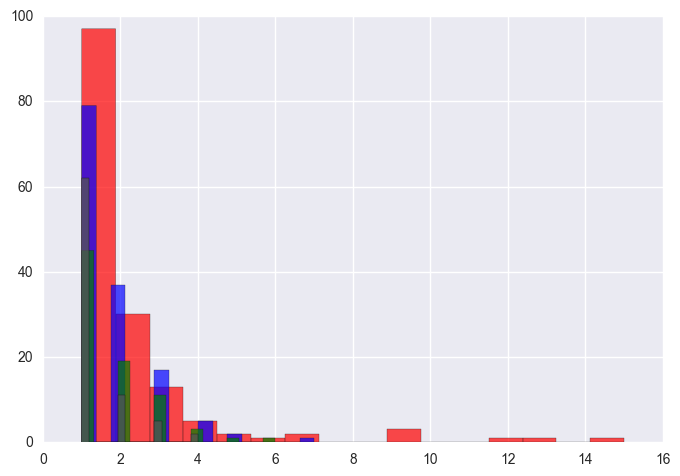

In [21]:
rel_df[rel_df["level_rel"]=="4-3"].groupby(by=["art_id"]).level_rel.count().hist(bins=16, color="red", alpha=0.7)
rel_df[rel_df["level_rel"]=="3-2"].groupby(by=["art_id"]).level_rel.count().hist(bins=16, color="blue", alpha=0.7)
rel_df[rel_df["level_rel"]=="3-1"].groupby(by=["art_id"]).level_rel.count().hist(bins=16, color="green", alpha=0.7)
rel_df[rel_df["level_rel"]=="2-1"].groupby(by=["art_id"]).level_rel.count().hist(bins=16, color="white", alpha=0.5)
rel_df[rel_df["level_rel"]=="2-1"].groupby(by=["art_id"]).level_rel.count().hist(bins=16, color="black", alpha=0.5)

plt.show()

# -------> TODO find the avg min max <-------

In [22]:
#avg, min max... groupby art_id and level_rel and then pivot table?
rel_df.groupby(by=["art_id","level_rel"]).level_rel.count()\
.reset_index([0,1], name="lvl_rel_count")


,art_id,level_rel,lvl_rel_count
0,3,4-3,4
1,9,4-3,2
2,11,3-2,2
3,11,4-3,2
4,12,2-1,1
5,12,3-2,2
6,13,3-2,1
7,13,4-3,1
8,16,3-2,1
9,20,4-3,1


## Types of Relationships by tag Distribution

In [23]:
rel_df.loc[:,"tag_rel"] = rel_df.c_tag.apply(lambda x: str(x)) + pd.Series(["-" for i in range(rel_df.shape[0])]) + rel_df.p_tag.apply(lambda x: str(x))
rel_df.tag_rel.value_counts()

City-State       241
Col-City         153
City-Country     139
Zone-City        131
State-Country    107
Bar-City          27
Zone-Country       5
Res-City           2
Zone-State         2
Col-Country        1
Name: tag_rel, dtype: int64

## Find single entities (not included in any relationship)

In [24]:
def find_singles(df):
    singles_column =[]
    for ix, article in df.iterrows():
        childs = [ x[0] for x in article.relationships ]
        parents = [ x[1] for x in article.relationships ]
        
        singles =[]
        for entity in article.entities:

            if entity not in childs and entity not in parents:
                singles.append(entity)
                
        singles_column.append(singles)
    
    df.loc[:,"singles"] = singles_column
    df.loc[:,"singles_count"] = df.singles.apply(lambda x: len(x))
    return df
    


find_singles(articles)[["singles","singles_count" ]].head()

,singles,singles_count
0,[],0
2,[],0
3,[],0
4,[],0
5,[],0


sum 196
count    274.000000
mean       0.715328
std        1.469838
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       11.000000
Name: singles_count, dtype: float64


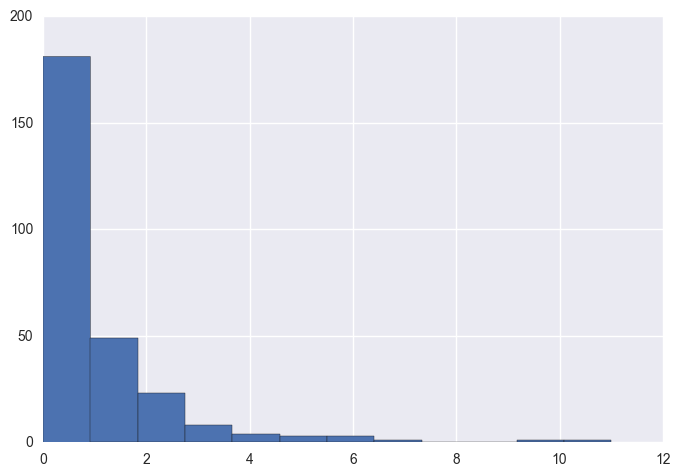

In [25]:
print "sum %i" %articles.singles_count.sum()
print articles.singles_count.describe()
articles.singles_count.hist(bins=12)
plt.show()

In [26]:
#count singles types
singles_types = {
    "Country": 0,
    "State": 0,
    "City": 0,
    "Zone": 0,
    "Col": 0,
    "Res": 0,
    "Bar": 0,
    "Misc":0
}
single_count = 0
for art_singles in articles.singles.values:
    for single in art_singles:
        singles_types[single["tag"]] += 1
        single_count+=1

print single_count
singles_types

196


{'Bar': 3,
 'City': 76,
 'Col': 20,
 'Country': 59,
 'Misc': 12,
 'Res': 2,
 'State': 8,
 'Zone': 16}

In [27]:
# Try to find mistakes in the data... singles that could have a parent
# level_map = {
#     "Country": 1,
#     "State": 2,
#     "City": 3,
#     "Zone": 4,
#     "Col": 4,
#     "Res": 4,
#     "Bar": 4
# }
possible_error = []
for ix, article in articles.iterrows():
    for single in article.singles:
        if single["tag"] == "Country" or single["tag"]=="Misc":
            continue
        elif single["tag"] == "State":
            if article.Country > 0:
                possible_error.append([article.article_id,single])
        elif single["tag"] == "City":
            if article.State > 0 or article.Country > 0:
                possible_error.append([article.article_id,single])
        else:
            if article.City > 0 or article.State > 0 or article.Country > 0:
                possible_error.append([article.article_id,single])
    
print len(possible_error)
possible_error

64


[[35, {'tag': u'City', 'word': 'trujilo'}],
 [55, {'tag': u'City', 'word': 'tegucigalpa'}],
 [63, {'tag': u'City', 'word': 'bangladesh'}],
 [63, {'tag': u'City', 'word': 'bandladesh'}],
 [66, {'tag': u'City', 'word': 'madrid'}],
 [66, {'tag': u'City', 'word': 'panama'}],
 [66, {'tag': u'City', 'word': 'quito'}],
 [78, {'tag': u'City', 'word': 'patuca'}],
 [78, {'tag': u'City', 'word': 'santa rosa de patuca'}],
 [92, {'tag': u'Col', 'word': 'luis andres zuniga'}],
 [197, {'tag': u'Col', 'word': 'el carrizal'}],
 [197, {'tag': u'City', 'word': 'sabanagrande'}],
 [197, {'tag': u'City', 'word': 'comayaguela'}],
 [321, {'tag': u'City', 'word': 'santa barbara'}],
 [394, {'tag': u'City', 'word': 'santa rosa de copan'}],
 [564, {'tag': u'Zone', 'word': 'kennedy'}],
 [726, {'tag': u'City', 'word': 'tegucigalpa'}],
 [819, {'tag': u'Zone', 'word': 'el sitio'}],
 [951, {'tag': u'City', 'word': 'beirut'}],
 [951, {'tag': u'City', 'word': 'londres'}],
 [1322, {'tag': u'City', 'word': 'comayaguela'}]

In [28]:
for ix , article in articles.iterrows():
    for single in article.singles:
        if single["tag"] not in ["Country"]:
            print str(article.article_id) + " " + single["tag"] + " " + single["word"] 

20 City valle de angeles
20 City el chimbo
20 City santa lucia
31 City tegucigalpa
31 City el chimbo
31 City valle de angeles
31 City san juancito
35 City trujilo
55 City tegucigalpa
63 City bangladesh
63 City bandladesh
66 Misc centroamerica
66 City madrid
66 City panama
66 City quito
78 City patuca
78 City santa rosa de patuca
79 City tegucigalpa
79 City tamara
92 Col luis andres zuniga
188 Col rivera hernandez
188 Col la gracias a dios
188 Col cerrito lindo
188 Col asentamientos humanos
188 Col felipe zelaya
188 Zone el tamarindo
197 Col el carrizal
197 City sabanagrande
197 State olancho
197 City comayaguela
320 State choluteca
321 City santa barbara
394 City santa rosa de copan
443 Misc caribe
469 Zone economica europea
469 Zone flor del campo
469 Zone mercado
469 Col flor del campo
524 City tegucigalpa
564 Zone kennedy
564 City suyapa
564 City azacualpa
726 City tegucigalpa
731 City tamara
731 City distrito central
806 City tegucigalpa
819 Zone el sitio
844 City tegucigalpa
865 C

### Observations


13 Cities/Zones are not from Honduras
- 63   City bangladesh
- 63   City bandladesh
- 66   City madrid
- 66   City panamá
- 66   City quito
- 380  City londres
- 951  City beirut
- 1355 City dakar
- 1385 City nueva orleáns
- 1509 City hollywood
- 1543 City bogotá
- 1543 Zone chigorodó
- 1543 Zone urabá










## Incomplete paths...

In [29]:
# get to the root
def getPath( ix, children, parents):
    tag_path = children[ix]["tag"]
    word_path = "["+children[ix]["word"]+"]"
    incomplete = False
    
    if parents[ix] in children:
        p_ix = children.index(parents[ix])
        pt_path, pw_path, incomplete = getPath(p_ix, children, parents)
        tag_path += "-" + pt_path
        word_path += "-" + pw_path
    else:
        tag_path += "-" + parents[ix]["tag"]
        word_path += "-[" + parents[ix]["word"] + "]"
        if parents[ix]["tag"] != "Country":
#             print "--- INCOMPLETE Country---"
            incomplete = True
        if children[ix]["tag"] not in ["Country","State","City"] and parents[ix]["tag"] != "City":
            incomplete = True
#             print "--- INCOMPLETE Zone---"
        
    return tag_path, word_path, incomplete

incompletes = []
for _, article in articles.iterrows():
    children = [ x[0] for x in article.relationships ]
    parents = [ x[1] for x in article.relationships ]

    for ix, entity in enumerate(children):
        if entity not in parents:
            tag_path, word_path, incomplete = getPath(ix, children, parents)
#             print word_path
            if incomplete:
#                 print str(article.article_id) + " " + word_path
                incompletes.append([article.article_id, word_path])
print len(incompletes)
# incompletes[:10]

314


### Observations

 Only two paths were not from Honduras:
- 986  [orlando]-[florida]
- 1111 [malecón costero]-[coatzacoalcos]

# Incompletes and Single Conclusions

Most of the incompletes will be completed by adding Honduras as country.
Most of the Singles can be completed by adding Tegucigalpa, San Pedro Sula or Honduras. Just a few of them have known international cities which can be found on a gazette.

### Convert to words distance


In [30]:


def getEntitydf(article):
    data = []
    word_count = 0
    for sent_id, sent in enumerate(article.full_text):
        for pos, word in enumerate(sent):
            if word[1][0] == "B":
                if len(data) > 0:
                    data[-1][-1] = word_count
                word_count = 0
                data.append([word[0].lower(),word[1][2:], sent_id, pos, 0 ])
            elif word[1][0] == "I":
                data[-1][0] += " " + word[0].lower()
            else:
                word_count += 1

    entity_df = pd.DataFrame(data, columns=["entity", "tag", "sent_id", "pos", "next_words"])


    return entity_df         

### Get pairs

In [31]:
def getPairs(article):
    article.entities
    country_entities = [x for x in article.entities if  x["tag"]=="Country"]
    state_entities = [x for x in article.entities if  x["tag"]=="State"]
    city_entities = [x for x in article.entities if  x["tag"]=="City"]
    zone_entities = [x for x in article.entities if  x["tag"] in ["Zone","Col","Res","Bar"]]

    pairs = []
    for child in zone_entities:
        for parent in city_entities + state_entities + country_entities:
            relation = int([child,parent] in article.relationships)
            pairs.append([child["tag"],child["word"],parent["tag"],parent["word"],child,parent, relation])

    for child in city_entities:
        for parent in  state_entities + country_entities:
            relation = int([child,parent] in article.relationships)
            pairs.append([child["tag"],child["word"],parent["tag"],parent["word"],child,parent, relation])

    for child in state_entities:
        for parent in country_entities:
            relation = int([child,parent] in article.relationships)
            pairs.append([child["tag"],child["word"],parent["tag"],parent["word"],child,parent, relation])
            
    #PRINT ODD RELATIONSHIPS     
#     for rel in article.relationships:
#         if rel[0] not in article.entities or rel[1]  not in article.entities:
#             print "- Treason in %i! end the following relationship:" %article.article_id
#             print rel
#             print "witnesses: "
#             print article.entities


    relations_df = pd.DataFrame(pairs,columns=["c_tag","c_word","p_tag","p_word","child","parent","label"])
    relations_df.loc[:,"rel_type"] = relations_df.c_tag +["-" for x in range(relations_df.shape[0])] +relations_df.p_tag 
    return relations_df

### get features for pairs

In [32]:
def getFeatures(relations_df,entity_df):
    #get the distances for each pair
    distances = []
    num_c_entity = []
    num_p_entity = []
    c_first = []
    p_first = []
    c_first_sent = []
    p_first_sent = []
    c_title = []
    p_title = []
    for _, pair in relations_df.iterrows():
        pair_distances = []

        #Number of occurences of the same entity
        num_c = entity_df[(entity_df["entity"]== pair.c_word)&(entity_df["tag"]== pair.c_tag)].shape[0]
        num_p = entity_df[(entity_df["entity"]== pair.p_word)&(entity_df["tag"]== pair.p_tag)].shape[0]
        num_c_entity.append(num_c)
        num_p_entity.append(num_p)

        #Is it in the first entity in the whole document?
        c_fe = 0 in entity_df[(entity_df["entity"]==pair.c_word)&(entity_df["tag"]==pair.c_tag)].index
        p_fe = 0 in entity_df[(entity_df["entity"]==pair.p_word)&(entity_df["tag"]==pair.p_tag)].index
        c_first.append(c_fe)
        p_first.append(p_fe)

        #Is it in the title?
        c_t = 0 in entity_df[(entity_df["entity"]==pair.c_word)&(entity_df["tag"]==pair.c_tag)].sent_id.values
        p_t = 0 in entity_df[(entity_df["entity"]==pair.p_word)&(entity_df["tag"]==pair.p_tag)].sent_id.values
        c_title.append(c_t)
        p_title.append(p_t)

        #Is it in the first sentence?
        c_fs = 1 in entity_df[(entity_df["entity"]==pair.c_word)&(entity_df["tag"]==pair.c_tag)].sent_id.values
        p_fs = 1 in entity_df[(entity_df["entity"]==pair.p_word)&(entity_df["tag"]==pair.p_tag)].sent_id.values
        c_first_sent.append(c_fs)
        p_first_sent.append(p_fs)

        indices = entity_df[(entity_df["entity"].isin([ pair.c_word,pair.p_word ])) \
                            & (entity_df["tag"].isin([pair.c_tag,pair.p_tag]))].index

        indices = sorted(indices)
        for i in range(len(indices)-1):
            for j in range(i+1,len(indices)):
                if entity_df.loc[indices[i]].tag == entity_df.loc[indices[j]].tag:
                    continue
                entity = entity_df.loc[indices[i]].entity
                distance = entity_df.loc[indices[i]:indices[j]-1].next_words.sum()
                #counting the entities in between
                if indices[j]-1 - indices[i] > 0: 
                    distance += entity_df.loc[indices[i]+1:indices[j]-1].next_words.count()
                pair_distances.append( distance )

        distances.append(pair_distances)
        
        

    relations_df.loc[:,"distances"] = pd.Series(distances)

    #minimum distance
    relations_df.loc[:,"minDistance"] = relations_df.distances.apply(lambda x: min(x))
    relations_df.loc[:,"maxDistance"] = relations_df.distances.apply(lambda x: max(x))
    relations_df.loc[:,"num_c_entity"] = num_c_entity
    relations_df.loc[:,"num_p_entity"] = num_p_entity

    relations_df.loc[:,"c_first"] = c_first
    relations_df.loc[:,"p_first"] = p_first
    relations_df.loc[:,"c_first_sent"] = c_first_sent
    relations_df.loc[:,"p_first_sent"] = p_first_sent
    relations_df.loc[:,"c_title"] = c_title
    relations_df.loc[:,"p_title"] = p_title
    
    #title or first
    relations_df.loc[:,"p_torf"] = relations_df.p_first_sent | relations_df.p_title
    relations_df.loc[:,"c_torf"] = relations_df.c_first_sent | relations_df.c_title
    
    relations_df.loc[:,"p_first"] = p_first
    
    
    relations_df.loc[:,"min_all"] = relations_df.child.apply(lambda x:  relations_df[relations_df["child"]==x].minDistance.min() )
    relations_df.loc[:,"num_rels"] = relations_df.child.apply(lambda x:  relations_df[relations_df["child"]==x].child.count() )
   

    return relations_df 


In [33]:
# Execute the functions
relationships = pd.DataFrame()
for _, article in articles.iterrows():
    if len(article.relationships) == 0:
        continue
    entity_df = getEntitydf(article)
    relations_df = getPairs(article)
    features_df = getFeatures(relations_df,entity_df)
    features_df.loc[:,"art_id"] = article.article_id
    relationships = pd.concat([relationships,features_df])
print "relatinionships size %i,%i"%(relationships.shape)
relationships.head()

relatinionships size 1956,24


,c_tag,c_word,p_tag,p_word,child,parent,label,rel_type,distances,minDistance,...,p_first,c_first_sent,p_first_sent,c_title,p_title,p_torf,c_torf,min_all,num_rels,art_id
0,Col,lomas del carmen,City,san pedro sula,"{u'tag': u'Col', u'word': u'lomas del carmen'}","{u'tag': u'City', u'word': u'san pedro sula'}",1,Col-City,"[82, 55, 38, 101]",38,...,True,False,True,False,False,True,False,38,1,3.0
1,Zone,monumento a la madre,City,san pedro sula,"{u'tag': u'Zone', u'word': u'monumento a la ma...","{u'tag': u'City', u'word': u'san pedro sula'}",1,Zone-City,"[138, 111, 94, 45]",45,...,True,False,True,False,False,True,False,45,1,3.0
2,Zone,primera avenida,City,san pedro sula,"{u'tag': u'Zone', u'word': u'primera avenida'}","{u'tag': u'City', u'word': u'san pedro sula'}",1,Zone-City,"[140, 113, 96, 43]",43,...,True,False,True,False,False,True,False,43,1,3.0
3,Zone,parque central,City,san pedro sula,"{u'tag': u'Zone', u'word': u'parque central'}","{u'tag': u'City', u'word': u'san pedro sula'}",1,Zone-City,"[142, 115, 98, 41]",41,...,True,False,True,False,False,True,False,41,1,3.0
0,Col,kennedy,City,tegucigalpa,"{u'tag': u'Col', u'word': u'kennedy'}","{u'tag': u'City', u'word': u'tegucigalpa'}",1,Col-City,[283],283,...,True,False,True,False,False,True,False,31,2,9.0


# Have fun with stats of pairs

## Average distance between positive pairs

In [34]:
relationships.columns

Index([u'c_tag', u'c_word', u'p_tag', u'p_word', u'child', u'parent', u'label',
       u'rel_type', u'distances', u'minDistance', u'maxDistance',
       u'num_c_entity', u'num_p_entity', u'c_first', u'p_first',
       u'c_first_sent', u'p_first_sent', u'c_title', u'p_title', u'p_torf',
       u'c_torf', u'min_all', u'num_rels', u'art_id'],
      dtype='object')

In [35]:
relationships[relationships["label"]==1][["minDistance","maxDistance","num_c_entity","num_p_entity"]].describe()

,minDistance,maxDistance,num_c_entity,num_p_entity
count,808.000000,808.000000,808.000000,808.000000
mean,48.248762,123.387376,1.264851,1.612624
std,85.862177,160.532956,0.667275,1.059419
min,0.000000,0.000000,1.000000,1.000000
25%,1.000000,8.000000,1.000000,1.000000
50%,8.000000,61.000000,1.000000,1.000000
75%,63.250000,175.500000,1.000000,2.000000
max,911.000000,950.000000,10.000000,10.000000


In [36]:
relationships[relationships["label"]==0][["minDistance","maxDistance","num_c_entity","num_p_entity"]].describe()

,minDistance,maxDistance,num_c_entity,num_p_entity
count,1148.000000,1148.000000,1148.000000,1148.000000
mean,127.619338,187.211672,1.277003,1.438153
std,179.284835,205.646609,0.883794,1.112898
min,0.000000,0.000000,1.000000,1.000000
25%,24.000000,44.000000,1.000000,1.000000
50%,63.000000,114.500000,1.000000,1.000000
75%,153.250000,249.000000,1.000000,1.000000
max,1299.000000,1299.000000,10.000000,10.000000


In [37]:
relationships[relationships["minDistance"]==973]

,c_tag,c_word,p_tag,p_word,child,parent,label,rel_type,distances,minDistance,...,p_first,c_first_sent,p_first_sent,c_title,p_title,p_torf,c_torf,min_all,num_rels,art_id


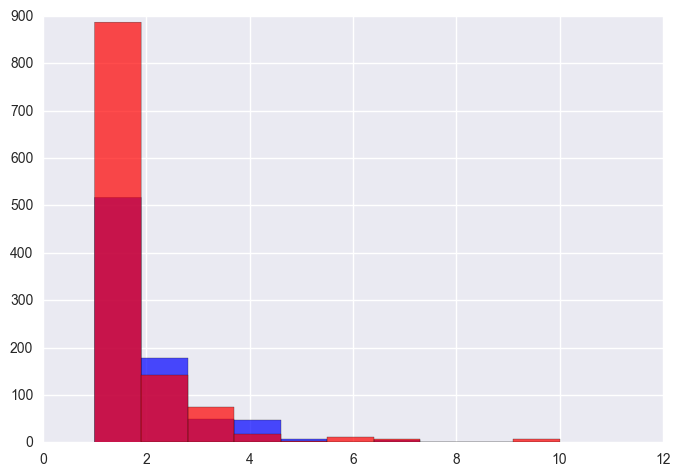

In [38]:
relationships[relationships["label"]==1].num_p_entity.hist(color="blue",alpha=.7)
relationships[relationships["label"]==0].num_p_entity.hist(color="red",alpha=.7)
plt.show()

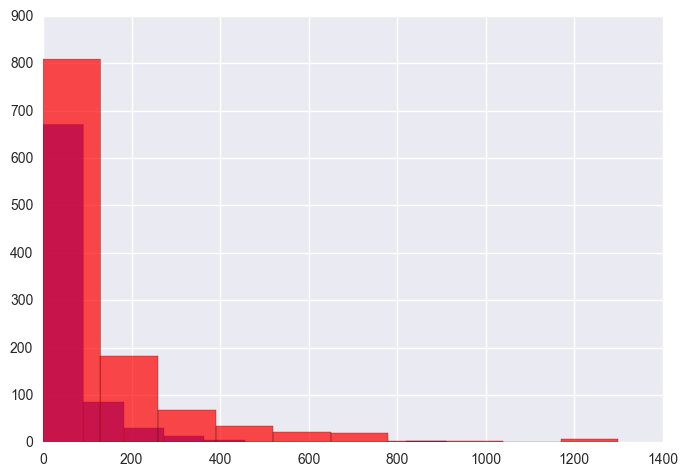

In [39]:
relationships[relationships["label"]==1].minDistance.hist(color="blue",alpha=.7)
relationships[relationships["label"]==0].minDistance.hist(color="red",alpha=.7)
plt.show()

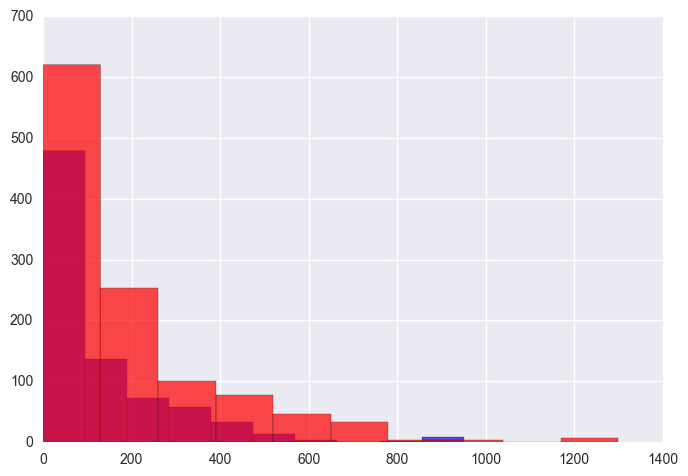

In [40]:
relationships[relationships["label"]==1].maxDistance.hist(color="blue",alpha=.7)
relationships[relationships["label"]==0].maxDistance.hist(color="red",alpha=.7)
plt.show()

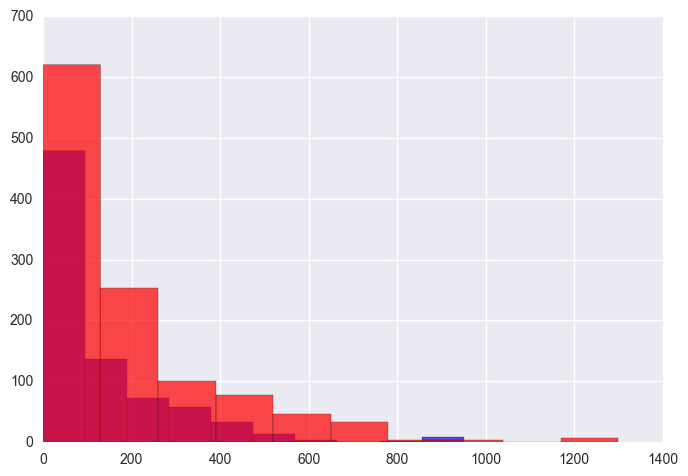

In [41]:
relationships.loc[:,"minmax"] = relationships.maxDistance - relationships.minDistance
relationships[relationships["label"]==1].maxDistance.hist(color="blue",alpha=.7)
relationships[relationships["label"]==0].maxDistance.hist(color="red",alpha=.7)
plt.show()

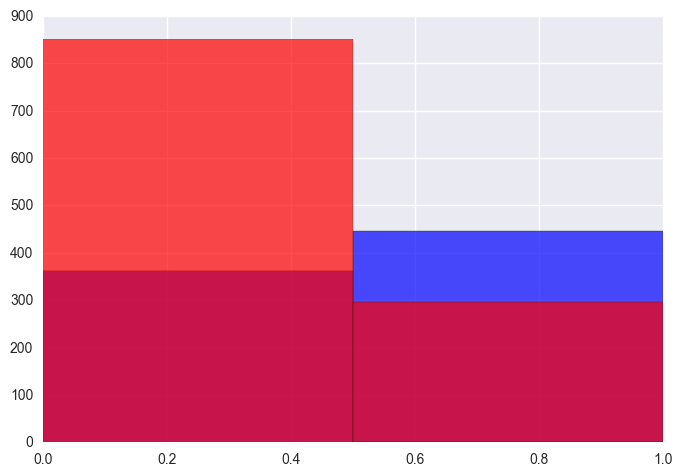

In [42]:
relationships[relationships["label"]==1].p_first_sent.hist(color="blue",alpha=.7,bins=2)
relationships[relationships["label"]==0].p_first_sent.hist(color="red",alpha=.7,bins=2)
plt.show()

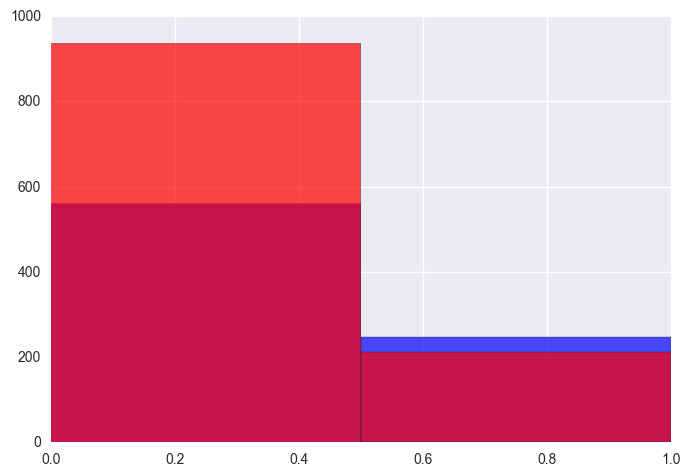

In [43]:
relationships[relationships["label"]==1].c_first_sent.hist(color="blue",alpha=.7,bins=2)
relationships[relationships["label"]==0].c_first_sent.hist(color="red",alpha=.7,bins=2)
plt.show()

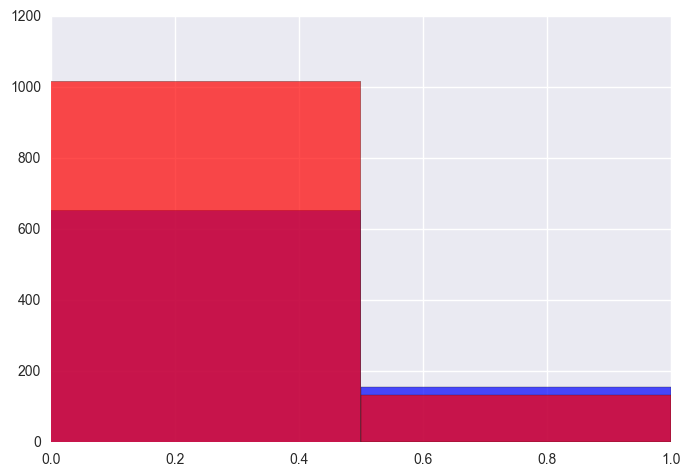

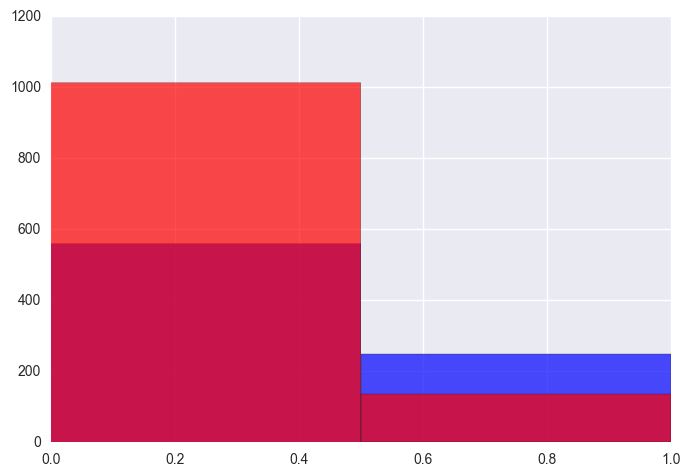

In [44]:
relationships[relationships["label"]==1].c_first.hist(color="blue",alpha=.7,bins=2)
relationships[relationships["label"]==0].c_first.hist(color="red",alpha=.7,bins=2)
plt.show()
relationships[relationships["label"]==1].p_first.hist(color="blue",alpha=.7,bins=2)
relationships[relationships["label"]==0].p_first.hist(color="red",alpha=.7,bins=2)
plt.show()

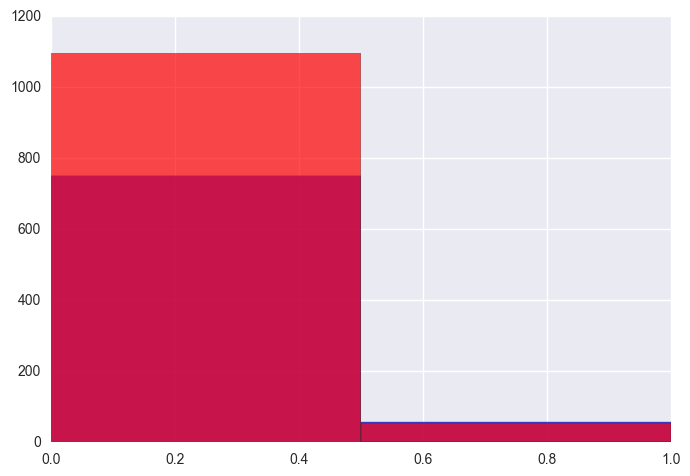

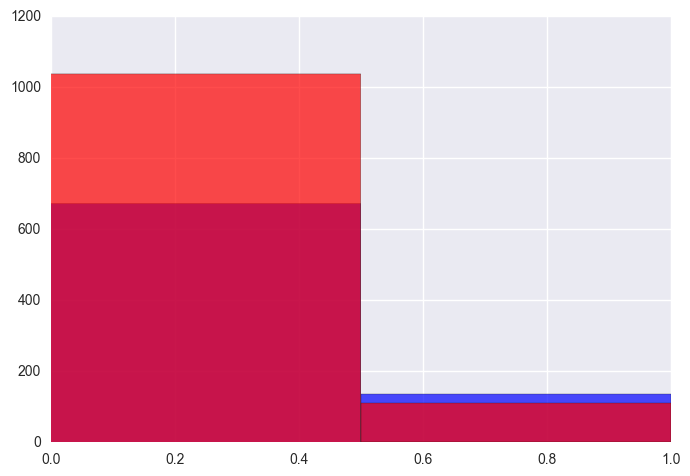

In [45]:
relationships[relationships["label"]==1].c_title.hist(color="blue",alpha=.7,bins=2)
relationships[relationships["label"]==0].c_title.hist(color="red",alpha=.7,bins=2)
plt.show()
relationships[relationships["label"]==1].p_title.hist(color="blue",alpha=.7,bins=2)
relationships[relationships["label"]==0].p_title.hist(color="red",alpha=.7,bins=2)
plt.show()

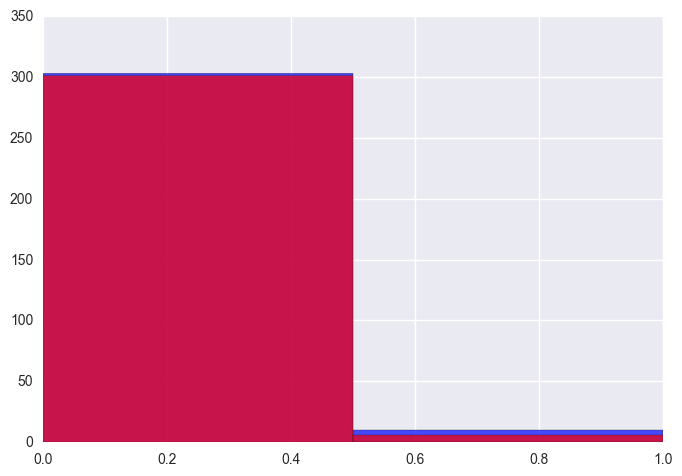

In [46]:
conditions = (relationships["c_tag"].isin(["Zone","Col","Res","Bar"]) )&(relationships["p_tag"]=="City")
relationships[conditions&(relationships["label"]==1)].c_title.hist(color="blue",alpha=.7,bins=2)
relationships[conditions&(relationships["label"]==0)].c_title.hist(color="red",alpha=.7,bins=2)
plt.show()

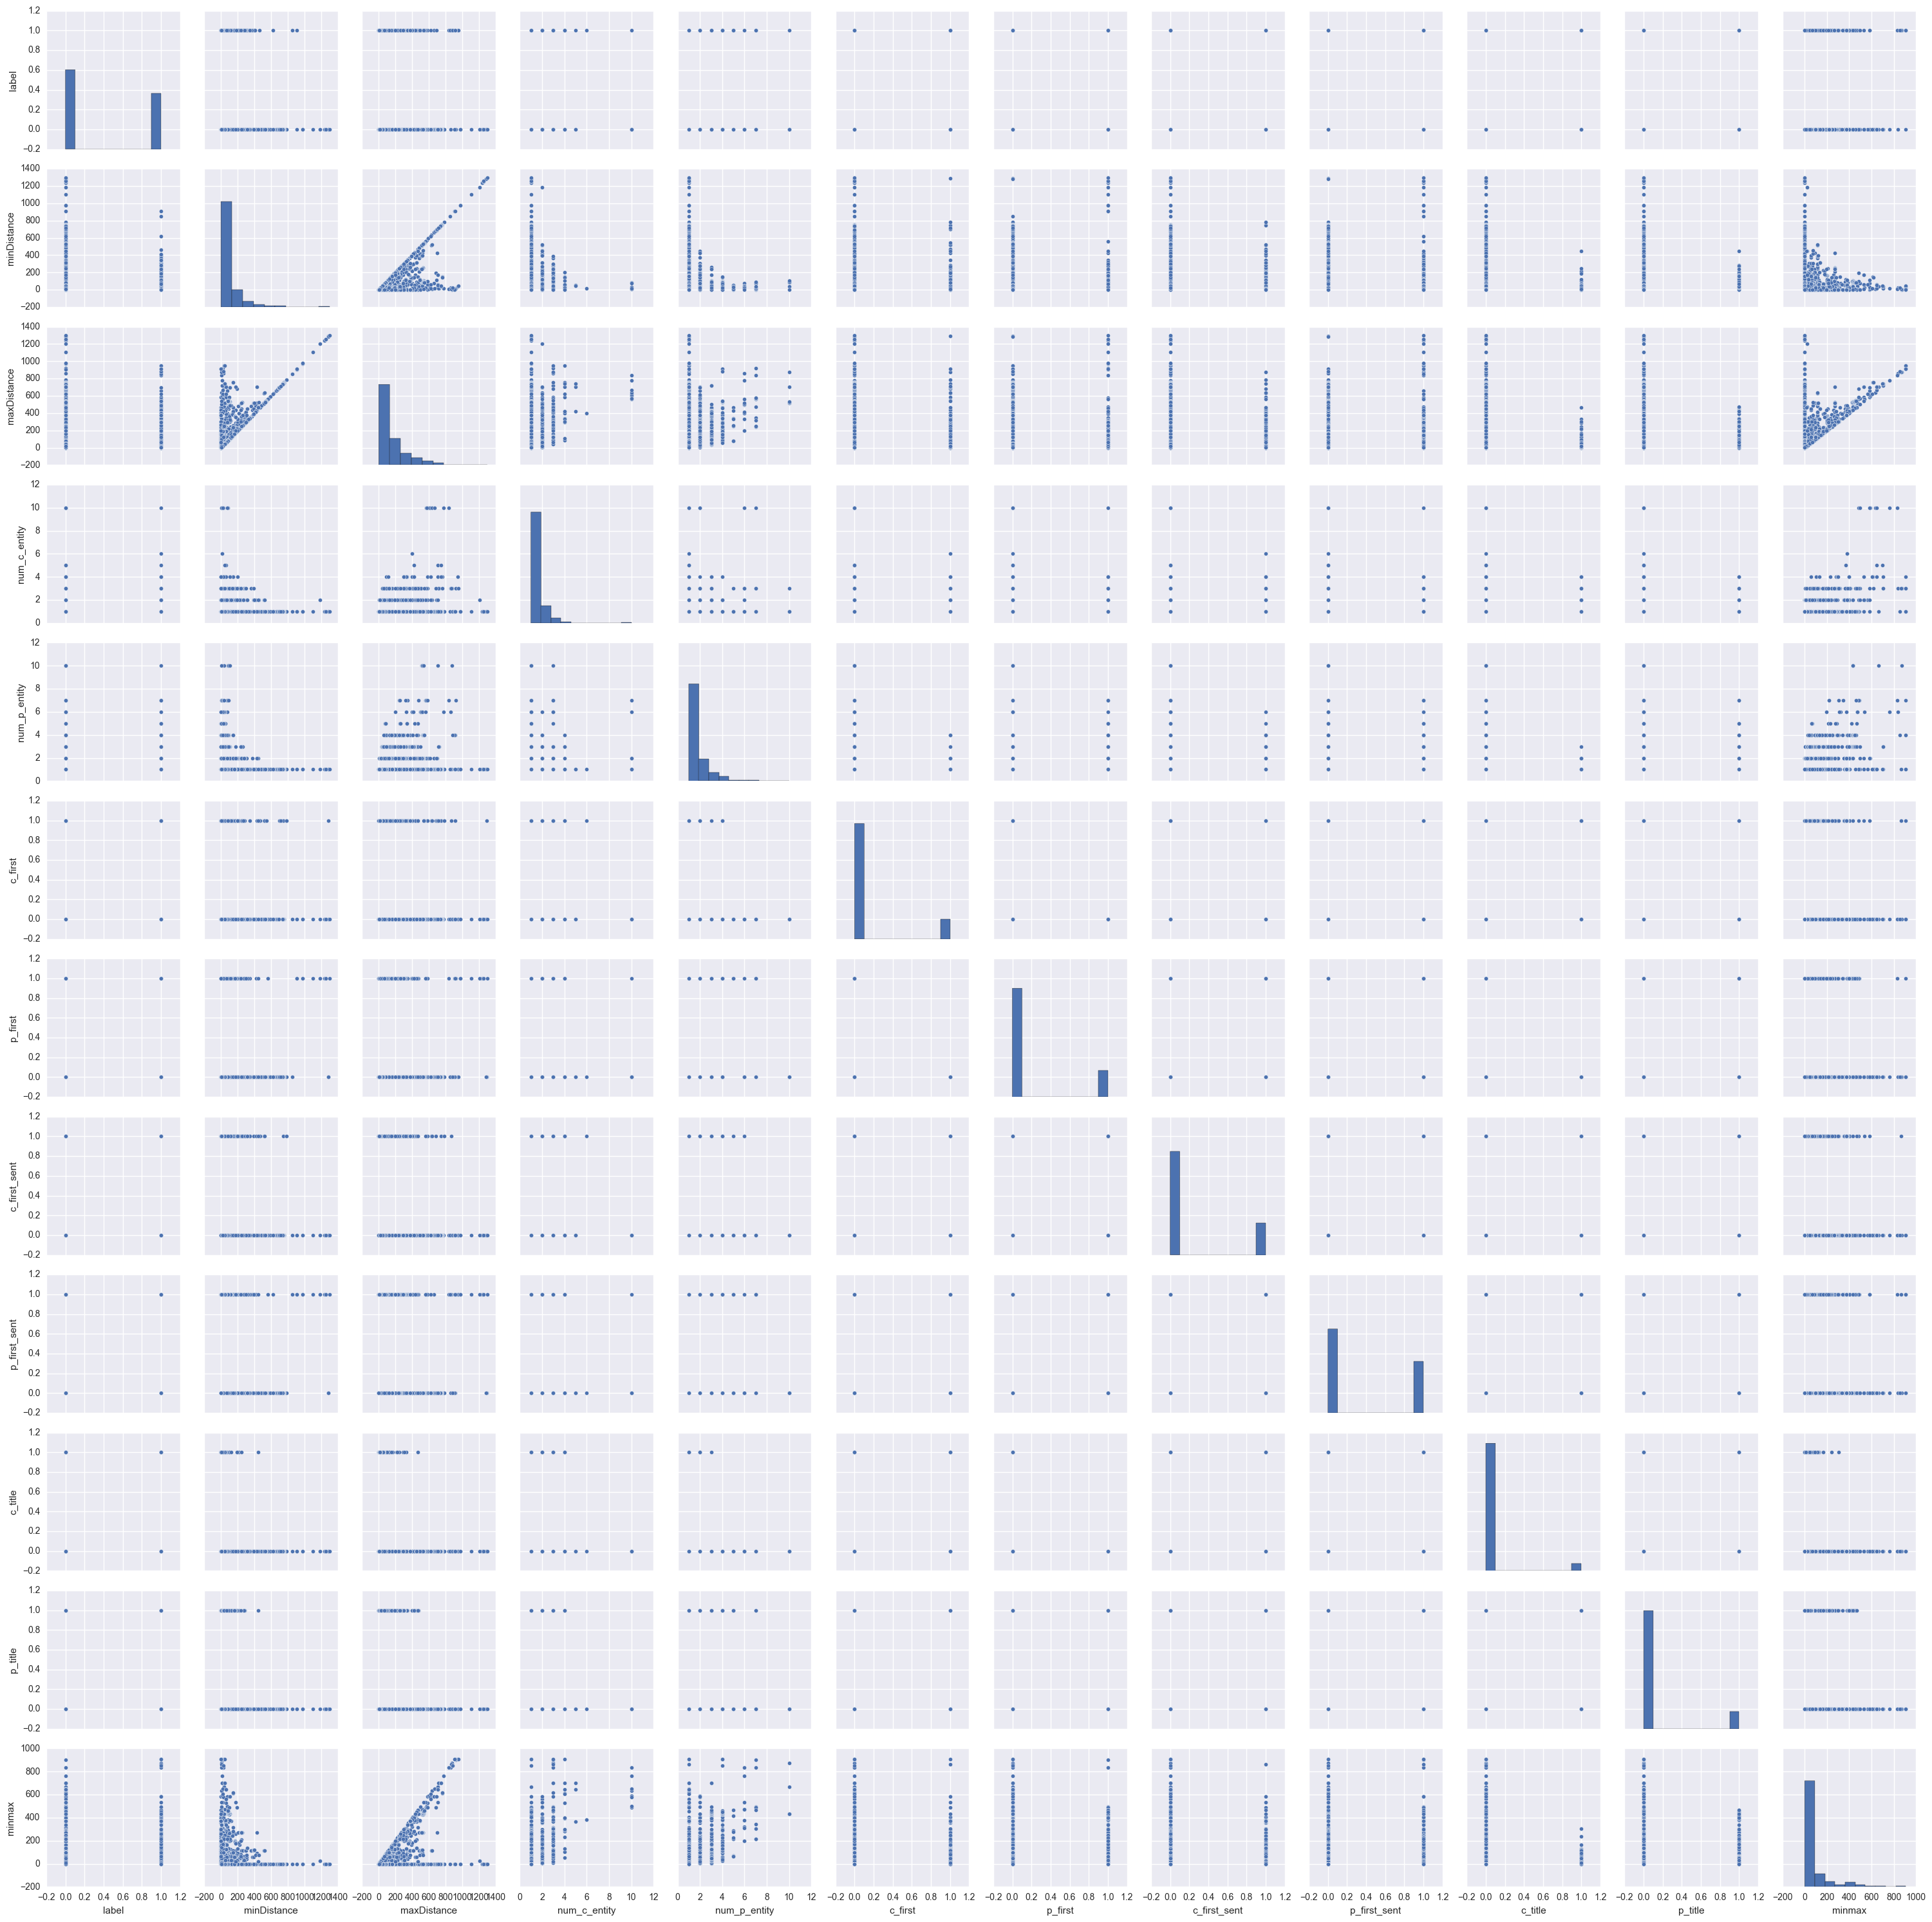

In [47]:
sns.pairplot(relationships[[
            'label',
            u'minDistance',u'maxDistance', 
            u'num_c_entity',u'num_p_entity',
            u'c_first',u'p_first', u'c_first_sent', u'p_first_sent',u'c_title',u'p_title',u'minmax',
    ]])
plt.show()

In [48]:
relationships.columns

Index([u'c_tag', u'c_word', u'p_tag', u'p_word', u'child', u'parent', u'label',
       u'rel_type', u'distances', u'minDistance', u'maxDistance',
       u'num_c_entity', u'num_p_entity', u'c_first', u'p_first',
       u'c_first_sent', u'p_first_sent', u'c_title', u'p_title', u'p_torf',
       u'c_torf', u'min_all', u'num_rels', u'art_id', u'minmax'],
      dtype='object')

# Try to use stats from Relationship type

In [49]:
rel_df.level_rel.value_counts()

4-3    313
3-2    241
3-1    139
2-1    107
4-1      6
4-2      2
Name: level_rel, dtype: int64

In [57]:
# relationships[conditions1].p_torf.value_counts().values.tolist() + [0]
np.arange(0,10,5)

array([0, 5])

['City-State']


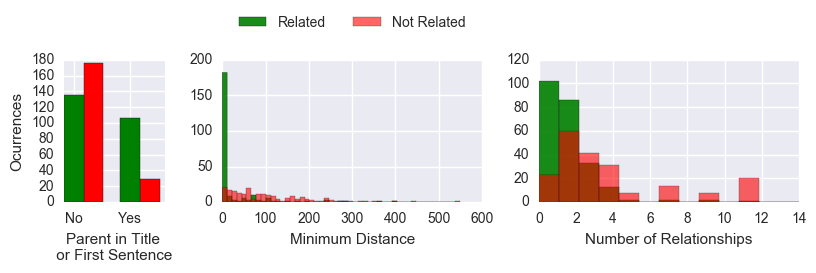

['Zone-City', 'Col-City', 'Res-City', 'Bar-City']


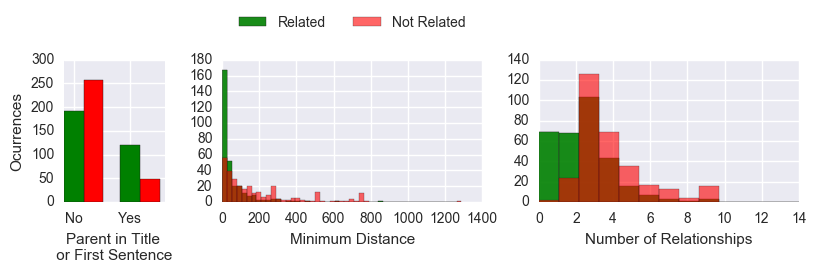

['City-Country']


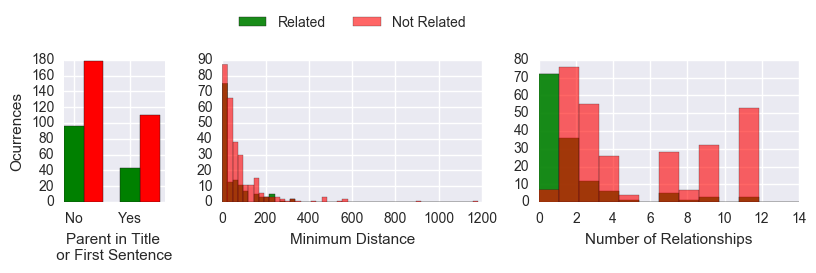

['State-Country']


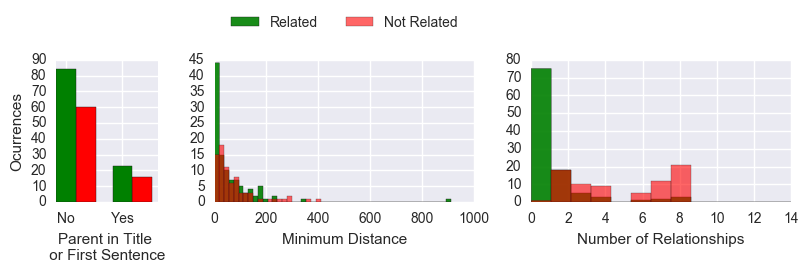

['Zone-Country', 'Col-Country']


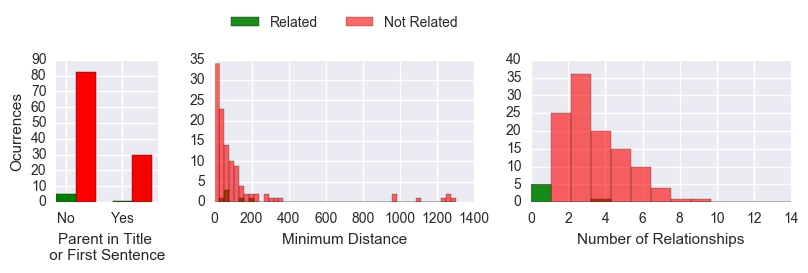

['Zone-State']


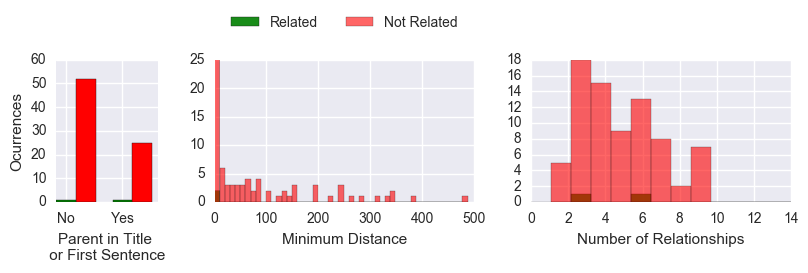

In [75]:
def visualize_reltype(rel_type):
    print rel_type
    fig = plt.figure()
    ax1 = plt.subplot2grid((3, 5), (0, 0))
    ax2 = plt.subplot2grid((3, 5), (0, 1), colspan=2)
    fig.tight_layout()

    #
    conditions1 =  (relationships["label"]==1) & (relationships["rel_type"].isin(rel_type) )
    conditions0 =  (relationships["label"]==0) & (relationships["rel_type"].isin(rel_type))
    
    bar_width = 0.35
    index = np.array([0,1])
    rects1 = ax1.bar(index + bar_width, relationships[conditions0].p_torf.value_counts(), bar_width,
                 color='red', label='Not Related')
    p_torf = relationships[conditions1].p_torf.value_counts()
    if len(p_torf) == 1:
        p_torf = p_torf.values.tolist() + [0]
    rects2 = ax1.bar(index, p_torf, bar_width,
                     color='green', label='Related')
    
    #TORF
    ax1.set_ylabel('Ocurrences')
    ax1.set_xlabel('Parent in Title \n or First Sentence ')
    ax1.set_xticks(index + bar_width / 2)
    ax1.set_xticklabels(('No','Yes'))
    
#     ax1.set_yticks(np.arange(0,200,30))
#     ax1.autoscale(enable=True, axis='both', tight=False)

#     ax1.legend()
    


    # Histogram
    bins = np.linspace(0, relationships[relationships["rel_type"].isin(rel_type)].minDistance.max(), 50)
    sns.distplot(relationships[conditions1].minDistance, color="green", hist_kws={'alpha':0.9},
                 bins=bins,kde=False, ax=ax2, label='Related')
    sns.distplot(relationships[conditions0].minDistance, color="red", hist_kws={'alpha':0.6},
                 bins=bins, kde=False, ax=ax2, label='Not Related')
    
    ax2.set_xlabel('Minimum Distance')
    ax2.legend()
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4),
          ncol=3, fancybox=True, shadow=True)
    # plt.xlabel('Minimum Distance')
    
    ax3 = plt.subplot2grid((3, 5), (0, 3), colspan=2)
    
    bins = np.linspace(0, 14, 14)
    sns.distplot(relationships[conditions1].num_rels, color="green", hist_kws={'alpha':0.9},bins=bins,kde=False, ax=ax3)
    sns.distplot(relationships[conditions0].num_rels, color="red", hist_kws={'alpha':0.6},bins=bins, kde=False, ax=ax3)
    ax3.set_xlabel('Number of Relationships')

    plt.show()

visualize_reltype(["City-State"])
visualize_reltype(["Zone-City", "Col-City","Res-City","Bar-City"])
visualize_reltype(["City-Country"])
visualize_reltype(["State-Country"])
visualize_reltype(["Zone-Country","Col-Country"])
visualize_reltype(["Zone-State"])

In [82]:
bins = np.linspace(0, relationships[relationships["rel_type"].isin(["Zone-State"])].minDistance.max(), 50)
sns.distplot(relationships[conditions1].minDistance, color="green", hist_kws={'alpha':0.9},
             bins=bins,kde=False, ax=ax2, label='Related')
sns.distplot(relationships[conditions0].minDistance, color="red", hist_kws={'alpha':0.6},
             bins=bins, kde=False, ax=ax2, label='Not Related')
plt.show()

NameError: name 'ax2' is not defined

['Zone-Country', 'Col-Country']


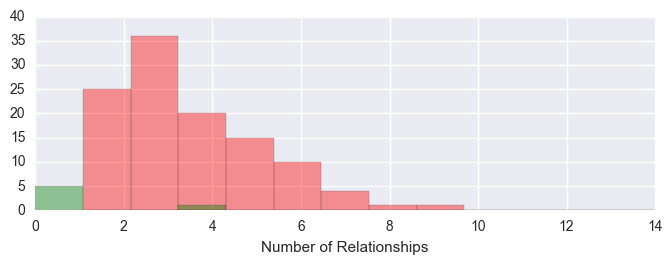

['City-State']


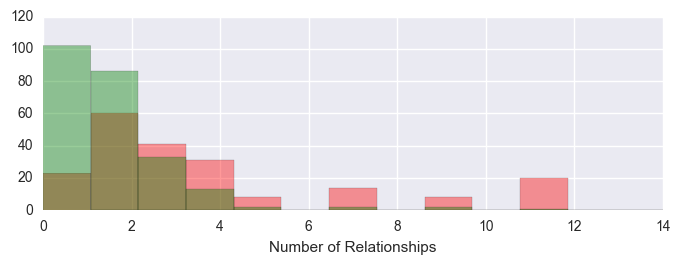

['Zone-City', 'Col-City', 'Res-City', 'Bar-City']


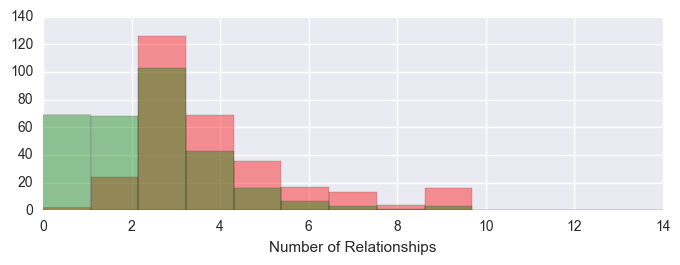

['City-Country']


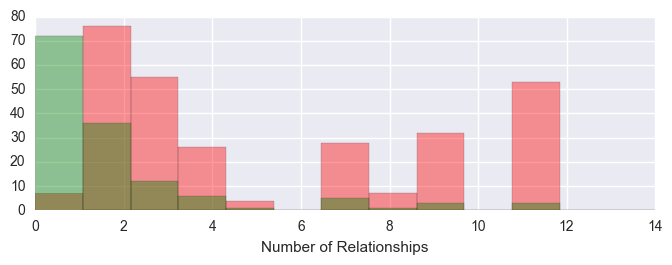

['State-Country']


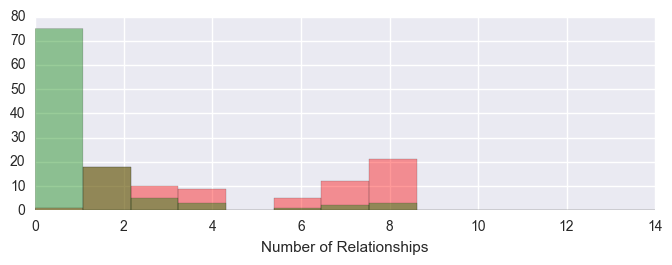

['Zone-State']


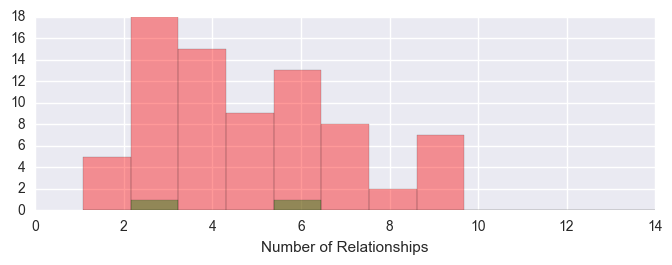

In [76]:
def visualize_num_rels(rel_type):
    print rel_type
    conditions1 =  (relationships["label"]==1) & (relationships["rel_type"].isin(rel_type) )
    conditions0 =  (relationships["label"]==0) & (relationships["rel_type"].isin(rel_type) )

#     relationships[conditions0].num_rels.hist(color="red",alpha=.7,bins=25)
#     relationships[conditions1].num_rels.hist(color="blue",alpha=.5,bins=25)
    ax2 = plt.subplot2grid((2, 1), (0, 0), colspan=2)
    
    bins = np.linspace(0, 14, 14)
    sns.distplot(relationships[conditions0].num_rels, color="red", bins=bins, kde=False, ax=ax2)
    sns.distplot(relationships[conditions1].num_rels, color="green", bins=bins,kde=False, ax=ax2)
    ax2.set_xlabel('Number of Relationships')
    
    plt.show()

visualize_num_rels(["Zone-Country","Col-Country"])
visualize_num_rels(["City-State"])
visualize_num_rels(["Zone-City", "Col-City","Res-City","Bar-City"])
visualize_num_rels(["City-Country"])
visualize_num_rels(["State-Country"])
visualize_num_rels(["Zone-State"])

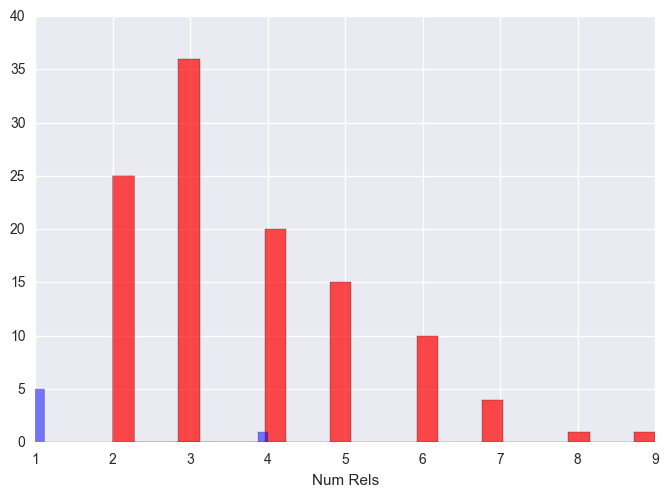

False    5
True     1
Name: p_torf, dtype: int64

In [77]:
conditions1 =  (relationships["label"]==1) & (relationships["rel_type"].isin(["Zone-Country","Col-Country"]) )
conditions0 =  (relationships["label"]==0) & (relationships["rel_type"].isin(["Zone-Country","Col-Country"]) )

relationships[conditions0].num_rels.hist(color="red",alpha=.7,bins=25)
relationships[conditions1].num_rels.hist(color="blue",alpha=.5,bins=25)
plt.xlabel('Num Rels')
plt.show()

relationships[conditions1].p_torf.value_counts()

In [78]:
def regplot(df,columns, conditions,logistic=False, truncate=False, joint=False,fig_size=None):
    sns.regplot(x=columns[0], y=columns[1], data=df[conditions[0]][columns], 
                color="red", logistic=logistic, truncate=truncate  )
    sns.regplot(x=columns[0], y=columns[1], data=df[conditions[1]][columns], 
                color="blue", logistic=logistic, truncate=truncate  )
    if joint:
        sns.jointplot(x=columns[0], y=columns[1], data=df[conditions[0]][columns], 
                    color="red", kind="reg" )
        sns.jointplot(x=columns[0], y=columns[1], data=df[conditions[1]][columns], 
                    color="blue", kind="reg" )
    if fig_size:
        plt.rcParams['figure.figsize']=fig_size
    plt.show()
    

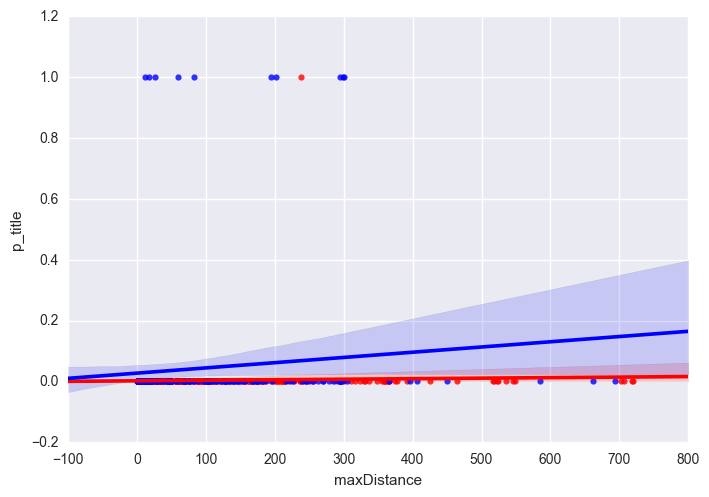

In [79]:
conditions1 =  (relationships["label"]==1) & (relationships["rel_type"]=="City-State") 
conditions0 =  (relationships["label"]==0) & (relationships["rel_type"]=="City-State") 
regplot(relationships,["maxDistance","p_title"], [conditions0, conditions1], fig_size=(3,2))

#  NEXT STEPS

Answer the following questions:
- **OK** How many "levels" each are in each article?
- **OK** How many relationships are in each article?
- **OK** How many Entities in each article?
- **OK** Is there a corelation between number of entities vs number of relationships?
- What are the types of relationships that exist? What are their distributions? Min, Max, Avg, Median?
- **OK** How many entities are single? 166
- **OK** How many relationships are "incomplete"? what info is missing? 290 and mostly country, a few (2) are city but it doesn't affect
- Numbers of Countries/States/Cities without any child entities?  --> why do you need this?

--> Features for relations???   Entity(lower level) -> Entity(higher level)

- **OK** Distance in words. (from closest, from farthest)
- **OK** Position in sentences and words. (Position of parent, Position of child, Position of nearest, Position of farthest)
- **OK** Quantity of entities (How many parent, How many child )
- Gazete test... 

(a lot of work still to be done)


In [80]:
dep_mun_df = pd.read_csv("../files/DepartamentosMunicipios.csv", encoding="utf-8")

dep_mun_df= dep_mun_df.append(pd.DataFrame([
        [u"francisco morazan",u"comayaguela"],
        [u"francisco morazan",u"distrito central"], 
    ],columns= dep_mun_df.columns), ignore_index=True
    )

dep_mun_df.Departamento = dep_mun_df.Departamento.apply(lambda x: to_ascii(x).lower() )
dep_mun_df.Municipio = dep_mun_df.Municipio.apply(lambda x: to_ascii(x).lower() )
dep_mun_df.loc[:,"combined"] = dep_mun_df.Municipio + ["-" for i in range(dep_mun_df.shape[0])] + dep_mun_df.Departamento

dep_mun_df.tail()

,Departamento,Municipio,combined
295,yoro,sulaco,sulaco-yoro
296,yoro,victoria,victoria-yoro
297,yoro,yorito,yorito-yoro
298,francisco morazan,comayaguela,comayaguela-francisco morazan
299,francisco morazan,distrito central,distrito central-francisco morazan


In [81]:
import pandas as pd
world_cities = pd.read_csv("../files/ciudades_mundo.csv", encoding="utf-8")
world_cities.country = world_cities.country.apply(lambda x: to_ascii(x).lower() )
world_cities.city = world_cities.city.apply(lambda x: to_ascii(x).lower() )
world_cities.loc[:,"combined"] = world_cities.city + ["-" for i in range(world_cities.shape[0])] + world_cities.country
world_cities.head()

,Unnamed: 0,city,country,combined
0,0,canton,china,canton-china
1,1,tokio,japon,tokio-japon
2,2,shangai,china,shangai-china
3,3,yakarta,indonesia,yakarta-indonesia
4,4,delhi,india,delhi-india


##  Gazette Classifier

In [83]:
rel_df.level_rel.value_counts()

4-3    313
3-2    241
3-1    139
2-1    107
4-1      6
4-2      2
Name: level_rel, dtype: int64

In [84]:
preds = []

city_states = []
for ix, rel in relationships.iterrows():
    
    # 2-1
    if rel.c_tag == "State":
        #search first in Honduras
        if rel.c_word in dep_mun_df.Departamento.values and rel.p_word == "honduras":
            preds.append(1)
#         elif rel.c_word in other_states:  #This could be improved by getting the list of USA, Mexico Colombia and others
        else:
            preds.append(0)
            
    # 3-2
    elif rel.c_tag == "City" and  rel.p_tag =="State":
        if rel.c_word +"-"+ rel.p_word in dep_mun_df.combined.values:
            preds.append(1)
            city_states.append([rel.c_tag,rel.c_word, rel.art_id])
        else:
            preds.append(0)
            
    
    # 3-1
    elif rel.c_tag == "City"and rel.p_tag == "Country":
        #if the same entity has a relationship with a state then implicit relation
        
        if [rel.c_tag, rel.c_word,rel.art_id] in city_states:
            preds.append(0)
            
        elif rel.c_word in dep_mun_df.Municipio.values and rel.p_word == "honduras":
            
            preds.append(1)
        elif rel.c_word + "-" + rel.p_word in world_cities.combined.values:
            
            preds.append(1)
        else:
#             print rel.c_word + "-" + rel.p_word
            preds.append(0)
    
    else:
        preds.append(0)
    

        
relationships.loc[:,"preds"] = preds
# relationships.loc[:,"preds"] = preds

In [88]:
rel_types = ["State-Country","City-Country","City-State"]
for rel_type in rel_types:
    print rel_type
    rel_filter = (relationships["rel_type"]==rel_type)
    label_filter = (relationships["label"]==1)
    preds_filter =(relationships["preds"]==1)
    
    tp = relationships[rel_filter&preds_filter&label_filter].label.count()
    pred_positives = relationships[rel_filter&preds_filter].preds.sum()
    real_positives = relationships[rel_filter&label_filter].label.sum()
    
    precision = (tp *1.0/pred_positives)
    recall = (tp *1.0/real_positives)
    f_score = ( 2.0 * precision * recall) / (precision + recall)
    
    print "tp: %0.4f"%tp
    print "pred_positives: %0.4f"%pred_positives
    print "real_positives: %0.4f"%real_positives
    print "precision: %0.4f"% precision
    print "recall: %0.4f"% recall
    print "f_score: %0.4f"%f_score
    print


State-Country
tp: 62.0000
pred_positives: 62.0000
real_positives: 107.0000
precision: 1.0000
recall: 0.5794
f_score: 0.7337

City-Country
tp: 99.0000
pred_positives: 107.0000
real_positives: 139.0000
precision: 0.9252
recall: 0.7122
f_score: 0.8049

City-State
tp: 144.0000
pred_positives: 145.0000
real_positives: 241.0000
precision: 0.9931
recall: 0.5975
f_score: 0.7461



In [86]:
filters = (relationships["rel_type"]=="State-Country") & (relationships["label"]==0) & (relationships["preds"]==1)
relationships[filters][["c_word","p_word","art_id"]]

,c_word,p_word,art_id


#17 copan - honduras why label =0  --> error

#State-Country
- No Mistakes
- Misses are not in the gazette

#City-Country 
- Mistakes were human mistakes or cities that have states that are not in the gazette
- Misses are not in the gazette

#City-State a lot of miss are because they aren't in the gazette


In [ ]:
dep_mun_df.Departamento.unique()

In [2]:
import pandas as pd
documents_df = pd.read_csv("../files/documents.csv")
documents_df.ix[:1999].tail()

,id,title,content,category,date
1995,1995,El certificado médico para pilotos debe inclui...,"Bruselas, (EFE).- La legislación comunitaria s...",Other,"27 Mar, 2015 - 9:34 am"
1996,1996,Lufthansa adopta la norma de dos personas en l...,"Fráncfort (Alemania), (EFE).- La compañía aére...",Other,"27 Mar, 2015 - 9:37 am"
1997,1997,Detenidos en Honduras seis inmigrantes de Ghan...,"Tegucigalpa, (ACAN-EFE).- Las autoridades de H...",Other,"27 Mar, 2015 - 9:49 am"
1998,1998,Plan y UNICEF presentan hoy informe sobre emba...,"Tegucigalpa, (ACAN-EFE).- El Fondo de las Naci...",Other,"27 Mar, 2015 - 9:58 am"
1999,1999,Bartomeu culpa Vilanova de adelantar el fichaj...,"El presidente del Fútbol Club Barcelona, Josep...",Other,"27 Mar, 2015 - 10:20 am"


In [8]:
articles_df = pd.read_csv("../files/pos_articles.csv")
print articles_df[articles_df["article_id"]<2000].shape
print articles_df[articles_df["article_id"]>=2000].shape

(239, 4)
(70, 4)
